<a href="https://colab.research.google.com/github/aangelopoulos/conformal_classification/blob/master/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring `RAPS`
This is a colab that shows you how to generate predictive sets guaranteed to contain the true class label with a probability you specify. 

This technique was proposed in our work [Uncertainty Sets for Image Classifiers using Conformal Prediction](https://arxiv.org/abs/).

## Setting up the experiments

**Make sure you're using a GPU** by setting "Runtime/Change runtime type/Hardware accelerator/" to "GPU" in the colab menu above.  

First, let's deal with imports, loading the pretrained model, and other boilerplate.

In [1]:
!rm -r conformal_classification
!git clone https://github.com/aangelopoulos/conformal_classification.git
import os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], './conformal_classification/'))

from conformal import *
from utils import *

# Import other standard packages
import argparse
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 
import time
import torch.backends.cudnn as cudnn
import random

# Fix the random seed for reproducibility (you can change this, of course) 
seed=0
np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

criterion = torch.nn.CrossEntropyLoss().cuda()
cudnn.benchmark = True
batch_size = 128

# Get your model
model = torchvision.models.resnet152(pretrained=True,progress=True).cuda()
_ = model.eval()

rm: cannot remove 'conformal_classification': No such file or directory
Cloning into 'conformal_classification'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 450 (delta 31), reused 113 (delta 15), pack-reused 310
Receiving objects: 100% (450/450), 2.68 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (238/238), done.


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Now download and extract ImageNet-Val. You only need to execute this cell once and it takes less than 5 minutes to run on my system.

In [ ]:
!wget -nv -O imagenet_val.tar.gz -L https://berkeley.box.com/shared/static/pouthcomrvxw9hj64oxhacjvqdw3ihlp.gz
!mkdir imagenet_val
!tar -xf imagenet_val.tar.gz -C ./imagenet_val/ 
!mv imagenet_val/scratch/group/ilsvrc/val/* imagenet_val/
!rm -r imagenet_val/scratch

2020-09-28 03:25:54 URL:https://public.boxcloud.com/d/1/b1!zJ3q4dMopsZJ9Dhou28eY9lh7TIJBFmnE_ifquis2JvFR4iwnrMe8YtFZ92Ll5SGnnTzxIC_P5gCteclgmdFyrwD7Hk2pXTZRxh9GSEVctkNHEdR8bVu_TsOhLprwx8hlYtf_9X2qW19dqvWCiUiiERzghP__WmjT0jZFbAHttcdpOfd_B2HTSoIQ5S3VXZZ8kWO0yIN1POyFF_BvwWF2O7kVe_RwlU5_iVkk2neitamOiOTsDKPbTgaUVDc5ks-mo_HPiFJwYgZeb5DhtUFRRAS-U50IpqGbZfGufBi8JL7Rho3XT7G_KHU7dTwiSi0YNhqLbqeVPHh-YD1d6xTfntIjSnCQ9HryPdpjQQ1QspOZyinicWix8Wfs4Xok3hI81ScxhkqfTuJo8_HfuYhAp-DI8mYW-t49NeKHEUTAcsiVZnxdyEZjyxPr46twWQgMWOo5yhVabSO0IziqxXnWMGENHf7JwCIxcodJXpfu4aA_XeiCk75PJoPRrhlyyLmvgdp_whlqCScgZ8lQfTk7PCqM7iCmP-FZyBek3kd6VIJWePoHx6DtWmvQPbfVxc9pAruQKIR_TBphQf-mYAXtQE4sL_ZB1hmRnrHDZZXq8cmk2vkOUjcOTr5F4NV278pULYwddSOflTv2xAEGxQZj3hEtIbCtqo7bOi4ckMW68xph1bIl0GQet_IYUpLQoUv2a057cR-ek3KbaY9uUr25TXHhYCjC5LomMclzMjwn7DkxZGrHgpIyymsLXzUzmrUe7gRWwrgDusHgQqyyh4J79Bhchl0MLp2ZgnUErVw8xc22yWJsV54RBSX0dtWXh88ohgejrOz1q9eEaaqhxhyjSPjMtCSfXe_ltyi3T7wuoTufC5qKazauN19VsDSHhBtiAJBBTZB5IDPEgWJOcBVsl3FrGK5yJh4_hA-f5k7t0_pQ

Now get the conformal calibration set and the validation dataset.

In [ ]:
num_calib = 5000

# Get the conformal calibration dataset
imagenet_calib_data, imagenet_val_data = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./imagenet_val/', transform), [num_calib,50000-num_calib])

# Initialize loaders 
calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)



## Conformalizing the model

This this the key step, where you perform Platt scaling and then wrap the model with `RAPS`.

 *(Did you catch the joke?)*

You should experiment with different values of `lamda`, `kreg`, and `alpha` to see how the set sizes change while coverage remains the same.

In [ ]:
# Conformalize model
cmodel = ConformalModel(model, calib_loader, alpha=0.1, kreg=5, lamda=0.01, randomized=True)

  0%|          | 0/40 [00:00<?, ?it/s]

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 40/40 [01:22<00:00,  2.07s/it]


Optimal T=1.2125694751739502


**Congratulations!** You can now output `1-alpha` predictive sets.


Now you can validate the coverage of your conformal model on the validation set with this utility function.

Running averages of coverage and size are in parentheses.

**Feel free to stop execution of this cell at any time**; otherwise it will run until `N=50,000-num_calib`, since that's the size of the validation set.

In [ ]:
top1, top5, coverage, size = validate(val_loader, cmodel, criterion, print_bool=True)

N: 45000 | Time: 2.159 (2.058) | Loss: 0.9562 (0.8779) | Cvg@1: 0.722 (0.783) | Cvg@5: 0.931 (0.940) | Cvg@RAPS: 0.903 (0.898) | Size@RAPS: 3.458 (3.833)


That's it! You're ready to use RAPS.

As a final visualization, running the next cell will just sample random 5 images and show their RAPS sets. Note that you can avoid sets of size zero by setting `randomized=False`.

It's interesting to see which images the model thinks are more difficult. 

2020-09-28 03:45:03 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14193/14193] -> "human_readable_labels.json" [1]
Image 0 has label 'revolver', and the predictive set is ['revolver'].
Image 1 has label 'house finch', and the predictive set is ['house finch', 'junco', 'chickadee'].
Image 2 has label 'Chesapeake Bay Retriever', and the predictive set is ['Chesapeake Bay Retriever', 'Labrador Retriever'].
Image 3 has label 'jellyfish', and the predictive set is ['jellyfish'].
Image 4 has label 'bison', and the predictive set is ['bison'].
Image 5 has label 'eastern diamondback rattlesnake', and the predictive set is ['night snake', 'African rock python', 'eastern diamondback rattlesnake', 'Saharan horned viper', 'water snake', 'sidewinder', 'Indian cobra', 'sea snake'].
Image 6 has label 'collie', and the predictive set is ['Tibetan Terrier', 'Old English Sheepdog', 'Lhasa Apso'].
Image 7 has label 'spotlight', and the predi

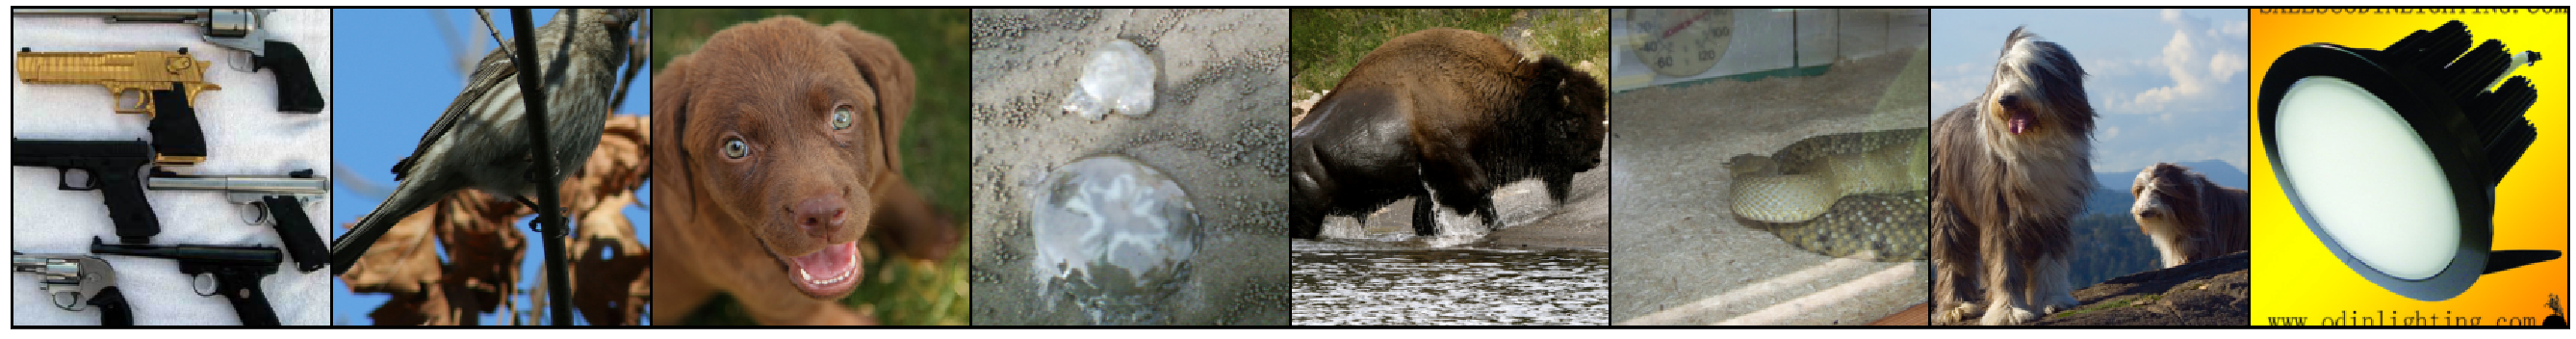

In [ ]:
num_images = 8
explore_data, _ = torch.utils.data.random_split(imagenet_val_data, [num_images, 50000-num_calib-num_images])

import pdb
import json

!wget -nv -O human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

with open('human_readable_labels.json') as f:
    labels = json.load(f)

labeldict = {}
for i in range(len(labels)):
  labeldict[i] = labels[i]
  
mosaiclist = []
sets = []
labels = []

for data in explore_data:
  img, label = data
  scores, set = cmodel(img.view(1,3,224,224).cuda())
  unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)
  
  set = [labeldict[s] for s in set[0]]
  sets = sets + [set]
  labels = labels + [labeldict[label]]
  mosaiclist = mosaiclist + [unnormalized_img]

grid = torchvision.utils.make_grid(mosaiclist)

fig, ax = plt.subplots(figsize=(min(num_images,9)*5, np.floor(num_images/9+1)*5))
ax.imshow(grid.permute(1,2,0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

for i in range(len(mosaiclist)):
  print(f"Image {i} has label \'{labels[i]}\', and the predictive set is {sets[i]}.")
